In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style='whitegrid', palette='deep')
import plotly.express as px

In [2]:
#use spotpy for calval
import spotpy

In [3]:
import pyGR4J as pG



In [4]:
norderney = pd.read_csv('/Users/cojack/Documents/TUBS/RUINS/data/Climate/norderney_daily_16_18.csv',index_col=0)
norderney.index = pd.to_datetime(norderney.index)
#norderney.head()

Q_darcy = pd.read_csv('/Users/cojack/Documents/TUBS/RUINS/data/1EVE_prozessdaten/Claudius_Notebooks/Q_gebiet/Q_darcy_m.csv',index_col=0)
Q_darcy.index = pd.to_datetime(Q_darcy.index)
#Q_darcy.resample('1d').sum().head()

In [5]:
tsx = pd.concat([norderney.Prec,norderney.EToSJ,1000.*Q_darcy.FBK],axis=1)
tsx.columns = ['Prec','ETact','Qknock']
tsx = pd.concat([tsx,1000.*Q_darcy.resample('1d').sum()],axis=1)
tsx = tsx.dropna()
tsx.head()

,Prec,ETact,Qknock,FBK,KKS,LAR,LW,VBM
2016-01-29,8.3,0.0,0.000000,1.515192,0.544948,5.482211,1.243169,1.360472
2016-01-30,8.5,0.0,0.017389,0.330940,1.591550,12.893762,1.823080,6.642955
2016-01-31,0.8,0.0,0.027462,1.334081,3.216302,6.040211,1.604589,1.941685
2016-02-01,0.3,0.0,0.047850,2.864597,2.325987,7.250653,1.931806,1.259583
2016-02-02,0.0,0.0,0.105840,1.488107,1.634957,5.502493,1.440160,1.015657


In [6]:
params = [2.40757648942523E+002,-4.80310910679438E-003,4.60127227314395E+000,3.36467040247373E+000,0.9]

#set weights of lag function
w1 = pG.tWeightsL1(params[3])
w2 = pG.tWeightsL2(params[3])

Qsim = pG.pyGR4J(tsx.values,params,w1,w2)
Qsim = pd.Series(Qsim,index=tsx.Qknock.index)

In [22]:
px.line(pd.concat([tsx.KKS,Qsim],axis=1,keys= ['OBS', 'SIM']), template='none')

In [12]:
class spotpy_setup(object):
    def __init__(self):
        self.params = [spotpy.parameter.Uniform('SMA',low=100.0 , high=800.,  optguess=2.40757648942523E+002),   #Capacity of the production soil (SMA) store (mm)
                       spotpy.parameter.Uniform('Wex',low=-0.01 , high=-0.0001,  optguess=-4.80310910679438E-003),#Water exchange coefficient (mm)
                       spotpy.parameter.Uniform('CapR',low=2.0 , high=6., optguess=4.60127227314395E+000), #Capacity of the routing store (mm)
                       spotpy.parameter.Uniform('Ti',low=1.5 , high=7.5, optguess=3.36467040247373E+000), #Time parameter (days) for unit hydrographs
                       spotpy.parameter.Uniform('Spl',low=0.5 , high=0.99, optguess=0.9)
                       ]
        self.evals = tsx.KKS.values
        
    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    def simulation(self,x):
        #set weights of lag function
        w1 = pG.tWeightsL1(x[3])
        w2 = pG.tWeightsL2(x[3])

        qsim = pG.pyGR4J(tsx.values,x,w1,w2)
        return qsim
    
    def evaluation(self):
        return self.evals
    
    def objectivefunction(self,simulation,evaluation, params=None):
        #try:
        #    like = spotpy.objectivefunctions.kge_non_parametric(evaluation,simulation) 
        #except:
        import hydroeval as he
        like = he.kge(simulation[40:],evaluation[40:])[0][0] #allow for 40 days spin-up
        return like

In [13]:
spot_setup=spotpy_setup()

In [14]:
#test
x = spot_setup.parameters()['random']
simulation = spot_setup.simulation(x)
spot_setup.objectivefunction(simulation,spot_setup.evaluation())

0.42890442948237995

In [21]:
px.line(pd.DataFrame([spot_setup.evaluation(),simulation],index=['OBS', 'SIM'], columns=tsx.index).T, template='none')


In [16]:
dbname = 'pyGR4J_KKSx'
rep = 1000
dream_sampler = spotpy.algorithms.dream(spot_setup, dbname='DREAM_'+dbname, dbformat='csv')
dream_sampler.sample(rep, nChains=6, convergence_limit=0.05, runs_after_convergence=200)



Initializing the  DiffeRential Evolution Adaptive Metropolis (DREAM) algorithm  with  100000  repetitions
The objective function will be minimized
Starting the DREAM algotrithm with 100000 repetitions...
Initialize  6  chain(s)...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'DREAM_pyGR4J_KKS.csv' created.
Beginn of Random Walk
17 of 100000, maximal objective function=0.609407, time remaining: 03:07:10
Acceptance rates [%] =100. 100. 100. 100. 100. 100.
Convergence rates =2.4087 3.4944 1.703  2.9547 1.4455
38 of 100000, maximal objective function=0.609407, time remaining: 02:52:43
Acceptance rates [%] =100.   100.   100.    83.33 100.    83.33
Convergence rates =2.5281 1.5757 1.8244 1.7467 1.7301
56 of 100000, maximal objective function=0.609407, time remaining: 02:58:37
Acceptance rates [%] =100.   100.   100.    88.89 100.    88.89
Convergence rates =1.74   1.618  1.3925 1.5068 1.5565
74 of 100000, maximal objective function=0.609407, time 

[array([2.31247124, 3.45549051, 2.71748782, 3.17530665, 1.32104985]),
 array([2.40869229, 3.49435659, 1.7030378 , 2.95469991, 1.44546144]),
 array([1.59374171, 1.24825766, 2.46802015, 2.58036702, 2.62856459]),
 array([1.92958672, 1.29625951, 2.02055673, 2.45625618, 2.56787592]),
 array([3.68113944, 1.61213269, 1.70249568, 1.85782006, 2.52060687]),
 array([2.52812304, 1.57568466, 1.82439689, 1.746691  , 1.73010672]),
 array([1.80577732, 1.72014097, 1.59581428, 1.35449622, 2.13417015]),
 array([1.64857273, 1.62056026, 1.40422146, 1.36768176, 1.82094453]),
 array([1.74004877, 1.61802069, 1.39246569, 1.50678842, 1.55647284]),
 array([1.5810117 , 1.64522519, 1.39315483, 1.4971267 , 1.36277132]),
 array([1.53470863, 1.46719412, 1.4207516 , 1.49740154, 1.23885951]),
 array([1.56319214, 1.42771976, 1.45598659, 1.51736101, 1.1970275 ]),
 array([1.52577594, 1.3099513 , 1.46575025, 1.29158724, 1.25145403]),
 array([1.45239425, 1.31472104, 1.41148919, 1.22667881, 1.26895781]),
 array([1.4495401 , 

In [17]:
import hydroeval as he
from scipy.stats import spearmanr
from scipy.stats import linregress

#dbname = 'pyGR4J_FBK'
eval = tsx.KKS
results = spotpy.analyser.load_csv_results('DREAM_'+dbname)
# Get fields with simulation data
fields = [word for word in results.dtype.names if word.startswith('sim')]
resDF = pd.DataFrame(results)
def eval2(x, y):
    return pd.Series(np.concatenate((linregress(x, y)[:], spearmanr(x, y)[:])),
                     index=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'spearman_corr', 'spearman_p'])
cidx = np.where(resDF.columns.str.contains("simulat"))[0]
resDF['KGE'] = np.nan
resDF['spearman_corr'] = np.nan
resDF['R2'] = np.nan

for i in resDF.index:
    resDF.loc[i, 'spearman_corr'] = eval2(eval.values, resDF.iloc[i, cidx].values)[-2]
    resDF.loc[i, 'R2'] = eval2(eval.values, resDF.iloc[i, cidx].values)[-3] ** 2
    resDF.loc[i, 'KGE'] = he.kge(resDF.iloc[i, cidx].values, eval.values)[0][0]



In [ ]:
figsize(15, 4)
#subplot(121)
for i in np.arange(len(resDF)):
    plot(eval.index, resDF.iloc[i, cidx].values, ':', c='gray', alpha=0.006)
plot(eval.index, eval.values, label='Observation')
#plot(eval.index, resDF.iloc[resDF['spearman_corr'].idxmax(), cidx].values, label='max spear')
plot(eval.index, resDF.iloc[resDF['KGE'].idxmax(), cidx].values, label='max KGE')

plot(eval.index, resDF.iloc[resDF['like1'].idxmax(), cidx].values, label='max like')
#plot(eval.index, resDF.iloc[resDF['like1'].idxmin(), cidx].values, label='max like')
legend()

#subplot(122)
#sns.distplot(eval.values, label='observed')
# sns.distplot(resDF.iloc[resDF['spearman_corr'].idxmax(),14:-4].values,label='max spear')
# sns.distplot(resDF.iloc[resDF['KGE'].idxmax(),14:-4].values,label='max KGE')

#sns.distplot(resDF.iloc[resDF['like1'].idxmax(), cidx].values, label='max like')
#sns.distplot(resDF.iloc[resDF['like1'].idxmin(), cidx].values, label='max like')
#legend()

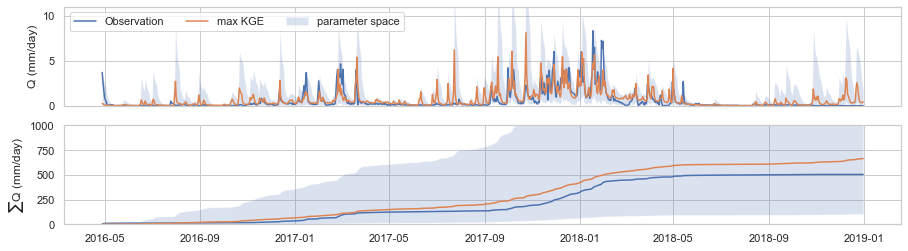

In [18]:
subplot(211)
fill_between(eval.index[90:], (resDF.iloc[:, cidx].min()[90:]), (resDF.iloc[:, cidx].max()[90:]), alpha=0.2,label='parameter space')

plot(eval.index[90:], (eval.values[90:]), label='Observation')
#plot(eval.index[90:], (resDF.iloc[resDF['like1'].idxmax(), cidx].values[90:]), label='max like')
plot(eval.index[90:], (resDF.iloc[resDF['KGE'].idxmax(), cidx].values[90:]), label='max KGE')

legend(ncol=3)
ylim(0,11)
ylabel('Q (mm/day)')
tick_params(labelbottom=False)

subplot(212)
fill_between(eval.index[90:], np.cumsum(resDF.iloc[:, cidx].min()[90:]), np.cumsum(resDF.iloc[:, cidx].max()[90:]), alpha=0.2,label='parameter space')

plot(eval.index[90:], np.cumsum(eval.values[90:]), label='Observation')
#plot(eval.index[90:], np.cumsum(resDF.iloc[resDF['like1'].idxmax(), cidx].values[90:]), label='max like')
plot(eval.index[90:], np.cumsum(resDF.iloc[resDF['KGE'].idxmax(), cidx].values[90:]), label='max KGE')

ylim(0,1000)
ylabel('$\sum$Q (mm/day)')
savefig('GR4J_KKS.pdf',bbox_inches='tight')

In [ ]:
resDF.loc[resDF['KGE']>=resDF['KGE'].quantile(0.999),resDF.columns[0:6]]